# How to calrep a two port file

In [1]:
from pyMeasure import *
from pyMeasure.Code.Analysis.NISTUncertainty import *


Importing Code.Utils.Names
Importing Code.DataHandlers.NISTModels
Importing Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.TouchstoneModels
Importing Code.DataHandlers.XMLModels
Importing Code.DataHandlers.RadiCALModels
Importing Code.DataHandlers.ZipModels
Importing Code.DataHandlers.Translations
Importing Code.DataHandlers.StatistiCALModels
Importing Code.DataHandlers.MUFModels
Importing Code.Analysis.SParameter
Importing Code.InstrumentControl.Instruments
Importing Code.InstrumentControl.Experiments


In [2]:
raw_file=TwoPortRawModel(os.path.join(TESTS_DIRECTORY,"TestFileTwoPortRaw.txt"))

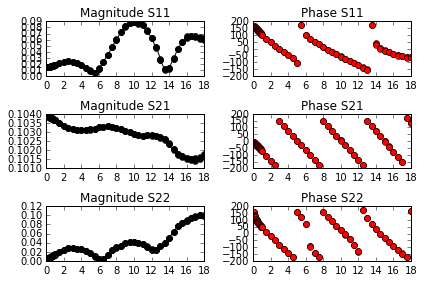

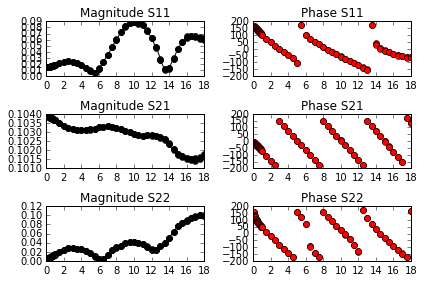

In [3]:
%matplotlib inline
raw_file.show()

In [4]:
mean_file=frequency_model_collapse_multiple_measurements(raw_file)
standard_deviation_file=frequency_model_collapse_multiple_measurements(raw_file,method="std")

In [5]:
mean_file.remove_column("Direction")
mean_file.remove_column("Connect")
standard_deviation_file.remove_column("Direction")
standard_deviation_file.remove_column("Connect")

In [6]:
raw_file.column_names

['Frequency',
 'Direction',
 'Connect',
 'magS11',
 'argS11',
 'magS21',
 'argS21',
 'magS22',
 'argS22']

In [7]:
mean_file.column_names

['Frequency', 'magS11', 'argS11', 'magS21', 'argS21', 'magS22', 'argS22']

In [8]:
mean_file.options["row_formatter_string"]

'{0:.5f}{delimiter}{1:.4f}{delimiter}{2:.2f}{delimiter}{3:.4f}{delimiter}{4:.2f}{delimiter}{5:.4f}{delimiter}{6:.2f}'

In [9]:
print standard_deviation_file.metadata

{'Connector_Type_Calibration': '', 'Number_Connects': '3', 'Number_Repeats': '1', 'Measurement_Time': '10:31:55', 'Measurement_Date': '9 Sep 2015', 'Start_Frequency': '7', 'Measurement_Type': '2-port', 'Device_Description': 'CHECK STANDARD 20 dB ATTEN', 'Calibration_Name': 'c050211.a2', 'Device_Id': 'CTN208', 'Connector_Type_Measurement': 'N', 'Nbs': '4', 'Number_Frequencies': '53', 'Program_Used': 'MEASLP', 'System_Letter': 'L', 'System_Id': 'HP8510', 'Operator': 'BFR', 'Program_Revision': '150122', 'Port_Used': '1', 'Calibration_Date': ''}


In [10]:
new_data=[]
new_column_names=[]
expansion_factor=2
frequency_index=mean_file.column_names.index("Frequency")
for row_index,row in enumerate(mean_file.data[:]):
    new_data_row=[]
    for column_index,column_name in enumerate(mean_file.column_names[:]):
        if re.search("frequency",column_name,re.IGNORECASE):
            if row_index==0:
                new_column_names.append("Frequency")
            new_data_row.append(row[column_index])
        else:
            if re.search("mag",column_name,re.IGNORECASE):
                error_selector=0
                error_letter="M"
                error_parameter=column_name.replace("mag","")
            elif re.search("arg|phase",column_name,re.IGNORECASE):
                error_selector=1
                error_letter="A"
                error_parameter=column_name.replace("arg","")
            elif re.search("Eff",column_name,re.IGNORECASE):
                error_selector=0
                error_letter="E"
                error_parameter=""
            else:
                error_selector=0
            if row_index==0:
                # If this is the first row build the column names list
                new_column_names.append(column_name)
                new_column_names.append("u"+error_letter+"b"+error_parameter)
                new_column_names.append("u"+error_letter+"a"+error_parameter)
                new_column_names.append("u"+error_letter+"d"+error_parameter)
                new_column_names.append("u"+error_letter+"g"+error_parameter)

            # Mean Value
            new_data_row.append(row[column_index])
            # Type B
            ub=type_b(wr_connector_type=mean_file.metadata["Connector_Type_Measurement"],
                     frequency=row[frequency_index],parameter=column_name,magnitude=row[column_index])
            new_data_row.append(ub[error_selector])
            # Type A or SNIST
            ua=S_NIST(wr_connector_type=mean_file.metadata["Connector_Type_Measurement"],
                     frequency=row[frequency_index],parameter=column_name,magnitude=row[column_index])
            new_data_row.append(ua[error_selector])

            # Standard Deviation
            ud=standard_deviation_file.data[row_index][column_index]
            new_data_row.append(ud)
            # Total Uncertainty
            #print(" ua is {0}, ub is {1} and ud is {2}".format(ua,ub,ud))
            total_uncertainty=expansion_factor*math.sqrt(ua[error_selector]**2+ub[error_selector]**2+ud**2)
            new_data_row.append(total_uncertainty)
    new_data.append(new_data_row)
sorted_keys=sorted(mean_file.metadata.keys()) 
header=["{0} = {1}".format(key,mean_file.metadata[key]) for key in sorted_keys]
column_types=["float" for column in new_column_names]
calrep=AsciiDataTable(None,data=new_data,column_types=column_types,column_names=new_column_names,header=header,metadata=mean_file.metadata)

In [11]:
print calrep.data[0:10]

[[0.10000000000000002, 0.01541, 0.001936904916768414, 0.00047599237966724985, 1.4142135623730373e-05, 0.003989170040047401, 169.11133333333336, 0.0017337484971055041, 0.00047599234371892263, 0.024553795814273433, 0.049239063413169276, 0.10390612936907699, 1.0276734293483746e-05, 8.132552211411996e-05, 4.751391356302364e-06, 0.00016421970082415599, -7.215333333333334, 0.03, 0.10170000000000001, 0.0012472191289243516, 0.21207966008606818, 0.004846666666666667, 0.001936904916768414, 0.00047599237966724985, 4.714045207910534e-06, 0.003989080908843624, 155.0413333333333, 0.001733755670441606, 0.00047599234371892263, 0.09805553981743813, 0.1961440426454524], [0.15, 0.01482, 0.001825809428138151, 0.00047851989635834037, 1.4142135623731192e-05, 0.0037750556865238207, 168.08533333333335, 0.002600588695219373, 0.0004785198598343108, 0.03805551500403808, 0.07629454148339909, 0.1038877085003118, 1.113699703118445e-05, 8.153608598489355e-05, 3.6765032291698373e-06, 0.00016475051073186584, -10.792, 

In [12]:
"argS11".title()

'Args11'

In [13]:
test_string="argS11"
"".join([s[0].upper() + s[1:] for s in test_string.split(' ')])

'ArgS11'

In [14]:
two_port_calrep=TwoPortCalrepModel(os.path.join(TESTS_DIRECTORY,"922729.asc"))

In [15]:
two_port_calrep.tables[1].column_names

['Frequency',
 'magS11',
 'uMbS11',
 'uMaS11',
 'uMdS11',
 'uMgS11',
 'argS11',
 'uAbS11',
 'uAaS11',
 'uAdS11',
 'uAgS11']

In [16]:
def calrep(raw_model,**options):
    """ Performs the calrep analysis routine on a raw data format (such as OnePortRawModel, TwoPortRawModel,PowerRawModel)
    Differs from the HP BASIC program in that it keeps the metadata"""
    mean_file=frequency_model_collapse_multiple_measurements(raw_model)
    standard_deviation_file=frequency_model_collapse_multiple_measurements(raw_model,method="std")
    mean_file.remove_column("Direction")
    mean_file.remove_column("Connect")
    standard_deviation_file.remove_column("Direction")
    standard_deviation_file.remove_column("Connect")
    new_data=[]
    new_column_names=[]
    expansion_factor=2
    frequency_index=mean_file.column_names.index("Frequency")
    for row_index,row in enumerate(mean_file.data[:]):
        new_data_row=[]
        for column_index,column_name in enumerate(mean_file.column_names[:]):
            if re.search("frequency",column_name,re.IGNORECASE):
                if row_index==0:
                    new_column_names.append("Frequency")
                new_data_row.append(row[column_index])
            else:
                if re.search("mag",column_name,re.IGNORECASE):
                    error_selector=0
                    error_letter="M"
                    error_parameter=column_name.replace("mag","")
                elif re.search("arg|phase",column_name,re.IGNORECASE):
                    error_selector=1
                    error_letter="A"
                    error_parameter=column_name.replace("arg","")
                elif re.search("Eff",column_name,re.IGNORECASE):
                    error_selector=0
                    error_letter="E"
                    error_parameter=""
                else:
                    error_selector=0
                if row_index==0:
                    # If this is the first row build the column names list
                    new_column_names.append(column_name)
                    new_column_names.append("u"+error_letter+"b"+error_parameter)
                    new_column_names.append("u"+error_letter+"a"+error_parameter)
                    new_column_names.append("u"+error_letter+"d"+error_parameter)
                    new_column_names.append("u"+error_letter+"g"+error_parameter)

                # Mean Value
                new_data_row.append(row[column_index])
                # Type B
                ub=type_b(wr_connector_type=mean_file.metadata["Connector_Type_Measurement"],
                         frequency=row[frequency_index],parameter=column_name,magnitude=row[column_index],format="mag")
                #print("{0} is {1}".format("ub",ub))
                new_data_row.append(ub[error_selector])
                # Type A or SNIST
                ua=S_NIST(wr_connector_type=mean_file.metadata["Connector_Type_Measurement"],
                         frequency=row[frequency_index],parameter=column_name,magnitude=row[column_index],format="mag")
                new_data_row.append(ua[error_selector])

                # Standard Deviation
                ud=standard_deviation_file.data[row_index][column_index]
                new_data_row.append(ud)
                # Total Uncertainty
                #print(" ua is {0}, ub is {1} and ud is {2}".format(ua,ub,ud))
                total_uncertainty=expansion_factor*math.sqrt(ua[error_selector]**2+ub[error_selector]**2+ud**2)
                new_data_row.append(total_uncertainty)
        new_data.append(new_data_row)
    sorted_keys=sorted(mean_file.metadata.keys()) 
    header=["{0} = {1}".format(key,mean_file.metadata[key]) for key in sorted_keys]
    column_types=["float" for column in new_column_names]
    calrep=AsciiDataTable(None,data=new_data,column_types=column_types,
                          column_names=new_column_names,header=header,metadata=mean_file.metadata)
    return calrep

In [17]:
new=calrep(raw_file)
#print new

In [18]:
import matplotlib.pyplot as plt
def plot_calrep(calrep_model):
    """Plots a calrep model with uncertainities"""
    if type(calrep_model) in [PowerCalrepModel,TwoPortCalrepModel]:
        calrep_model.joined_table.metadata=calrep_model.metadata
        calrep_model=calrep_model.joined_table
        
    # Uncertainties all have u in them 
    average_columns=[]
    for column_name in calrep_model.column_names[:]:
        if re.search("mag|arg|eff",column_name,re.IGNORECASE):
            average_columns.append(column_name)
    print("{0} is {1}".format("average_columns",average_columns))
    number_plots=len(average_columns)
    number_rows=int(round(number_plots/2.))
    fig, axes = plt.subplots(nrows=number_rows, ncols=2, sharex='col')
    for plot_index,ax in enumerate(axes.flat):
        column_name=average_columns[plot_index]
        ax.set_title(column_name)
        if re.search("mag",column_name,re.IGNORECASE):
            error_letter="M"
            error_parameter=column_name.replace("mag","")
            error_name="u"+error_letter+"g"+error_parameter
            error=calrep_model[error_name]
            x=calrep_model["Frequency"]
            y=calrep_model[column_name]
            print("Length of x is {0}, Length of y is {1}, Length of error is {2}".format(len(x),len(y),len(error)))
            ax.errorbar(x,y,yerr=error,fmt='k--')
            ax.set_ylabel(r'|${\Gamma} $|',color='green')
        elif re.search("arg",column_name,re.IGNORECASE):
            error_letter="A"
            error_parameter=column_name.replace("arg","")
            error_name="u"+error_letter+"g"+error_parameter
            error=calrep_model[error_name]
            x=calrep_model["Frequency"]
            y=calrep_model[column_name]
            ax.errorbar(x,y,yerr=error,fmt='k--')
            ax.set_ylabel('Phase(Degrees)',color='green')
        elif re.search("eff",column_name,re.IGNORECASE):
            error_letter="E"
            error_parameter=""
            try:
                error_name="u"+error_letter+"g"+error_parameter
                error=calrep_model[error_name]
            except:
                error_name="u"+error_letter+"e"+error_parameter
                error=calrep_model[error_name]
            
            x=calrep_model["Frequency"]
            y=calrep_model[column_name]
            ax.errorbar(x,y,yerr=error,fmt='k--')
            ax.set_ylabel('Phase(Degrees)',color='green')
            break
    fig.suptitle(calrep_model.metadata["Device_Id"])
    plt.tight_layout()
    plt.show()
    return fig
        
        
        
        
        
def plot_calrep_comparision(calrep_model_list):
    """Plots many calrep models on the same axis with uncertainities"""
    for index,calrep_model in enumerate(calrep_model_list):
        if type(calrep_model) in [PowerCalrepModel,TwoPortCalrepModel]:
            calrep_model_list[index].joined_table.metadata=calrep_model.metadata
            calrep_model_list[index]=calrep_model.joined_table

        # Uncertainties all have u in them 
    average_columns=[]
    for column_name in calrep_model_list[0].column_names[:]:
            if re.search("mag|arg|eff",column_name,re.IGNORECASE):
                average_columns.append(column_name)
    print("{0} is {1}".format("average_columns",average_columns))
    number_plots=len(average_columns)
    number_rows=int(round(number_plots/2.))
    fig, axes = plt.subplots(nrows=number_rows, ncols=2, sharex='col')
    for calrep_model in calrep_model_list:
        for plot_index,ax in enumerate(axes.flat):
            column_name=average_columns[plot_index]
            ax.set_title(column_name)
            if re.search("mag",column_name,re.IGNORECASE):
                error_letter="M"
                error_parameter=column_name.replace("mag","")
                error_name="u"+error_letter+"g"+error_parameter
                error=calrep_model[error_name]
                x=calrep_model["Frequency"]
                y=calrep_model[column_name]
                ax.errorbar(x,y,yerr=error)
                ax.set_ylabel(r'|${\Gamma} $|',color='green')
            elif re.search("arg",column_name,re.IGNORECASE):
                error_letter="A"
                error_parameter=column_name.replace("arg","")
                error_name="u"+error_letter+"g"+error_parameter
                error=calrep_model[error_name]
                x=calrep_model["Frequency"]
                y=calrep_model[column_name]
                ax.errorbar(x,y,yerr=error)
                ax.set_ylabel('Phase(Degrees)',color='green')
            elif re.search("eff",column_name,re.IGNORECASE):
                error_letter="E"
                error_parameter=""
                try:
                    error_name="u"+error_letter+"g"+error_parameter
                    error=calrep_model[error_name]
                except:
                    error_name="u"+error_letter+"e"+error_parameter
                    error=calrep_model[error_name]

                x=calrep_model["Frequency"]
                y=calrep_model[column_name]
                ax.errorbar(x,y,yerr=error)
                ax.set_ylabel('Phase(Degrees)',color='green')
                break
    plt.tight_layout()
    plt.show()
    return fig

average_columns is ['magS11', 'argS11', 'magS21', 'argS21', 'magS22', 'argS22']
Length of x is 53, Length of y is 53, Length of error is 53
Length of x is 53, Length of y is 53, Length of error is 53
Length of x is 53, Length of y is 53, Length of error is 53


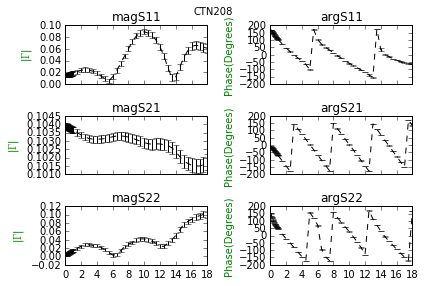

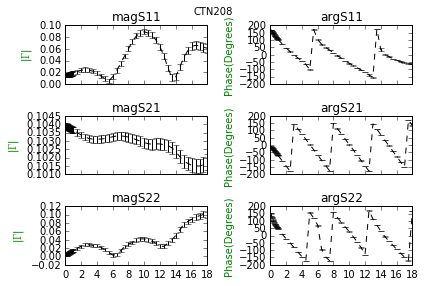

In [19]:
plot_calrep(new)

In [20]:
one_port_raw=OnePortRawModel(os.path.join(TESTS_DIRECTORY,'OnePortRawTestFile.txt'))

average_columns is ['magS11', 'argS11']
Length of x is 10, Length of y is 10, Length of error is 10


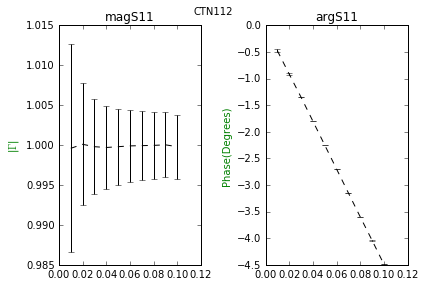

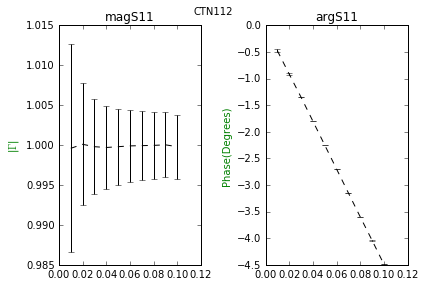

In [21]:
new_2=calrep(one_port_raw)
plot_calrep(new_2)

average_columns is ['magS11', 'argS11', 'magS21', 'argS21', 'magS22', 'argS22']
Length of x is 179, Length of y is 179, Length of error is 179
Length of x is 179, Length of y is 179, Length of error is 179
Length of x is 179, Length of y is 179, Length of error is 179


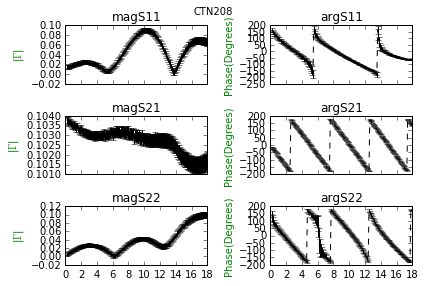

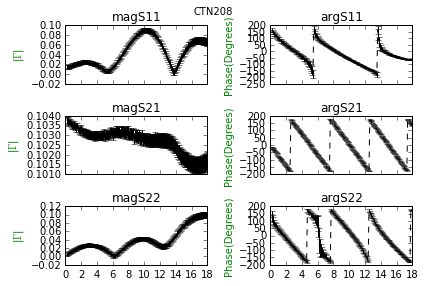

In [22]:
old_calrep=TwoPortCalrepModel(os.path.join(r"C:\Share\ascii.dut\2014",'CTN208.asc'))
#plot_calrep(old_calrep)
old_calrep.tables[2].column_names
old_calrep.table_names
plot_calrep(old_calrep)

average_columns is ['magS11', 'argS11', 'magS21', 'argS21', 'magS22', 'argS22']
Length of x is 181, Length of y is 181, Length of error is 181
Length of x is 181, Length of y is 181, Length of error is 181
Length of x is 181, Length of y is 181, Length of error is 181


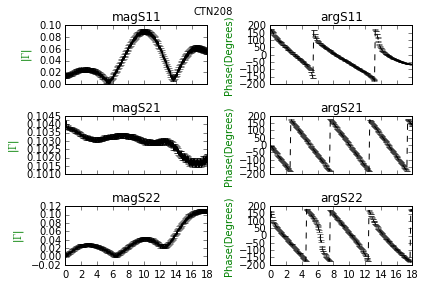

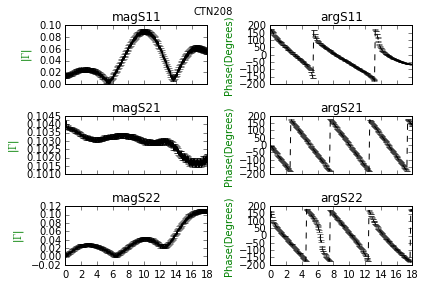

In [23]:
raw=TwoPortRawModel(os.path.join(r"C:\Share\Ck_Std_raw_ascii",'CTN208.L26_121399'))
new_calrep=calrep(raw)
plot_calrep(new_calrep)
#print raw

average_columns is ['magS11', 'argS11', 'magS21', 'argS21', 'magS22', 'argS22']


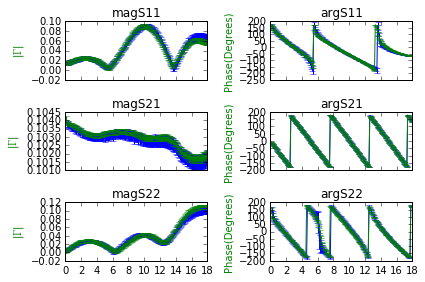

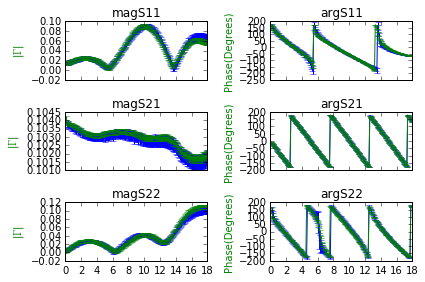

In [24]:
%matplotlib inline
plot_calrep_comparision([old_calrep,new_calrep])

In [25]:
-20.*math.log10(.14)

17.07743928643524

In [26]:
umag=20**(-2.17+.024*18)/2
mag=.1
print abs((1/math.log10(math.e))*mag*umag/20.)
print umag

3.15475447383e-05
0.00274018491948


In [27]:
math.log(.5)

-0.6931471805599453

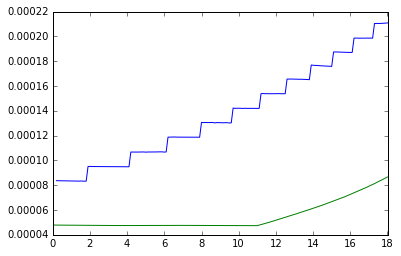

In [28]:
%matplotlib inline
#old_calrep.joined_table.column_names

plt.plot(old_calrep.joined_table["Frequency"],old_calrep.joined_table["uMaS21"])
plt.plot(new_calrep["Frequency"],np.array(new_calrep["uMaS21"]))

In [29]:
print old_calrep.joined_table["uMaS21"][0]
print new_calrep["uMaS21"][0]
print new_calrep["uMaS21"][2]/old_calrep.joined_table["uMaS21"][2]
print 2*10**(1./2.)

8.36149112337e-05
4.79494040084e-05
0.571961270892
6.32455532034


In [30]:
from types import *
type(old_calrep)==PowerCalrepModel

False

In [31]:
old_calrep.metadata

{'Analysis_Date': '16 Feb 2014', 'Device_Id': 'CTN208'}

In [32]:
S_NIST(wr_connector_type="N",frequency=1.0,magnitude=19.699,format="dB",parameter="S12")

[0.007144963260755135, 0.0783429642766212]

In [33]:
type_b(wr_connector_type="N",frequency=1.0,magnitude=19.699,format="dB",parameter="S12")

[0.001672901904302951, 0.03]

The self.metadata["Device_Id"] variable is CTN102
average_columns is ['magS11', 'argS11']


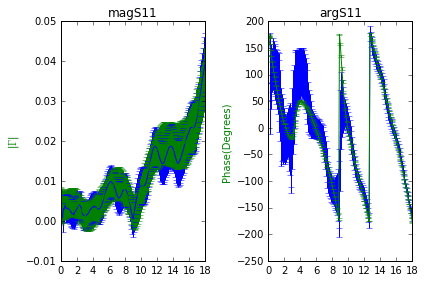

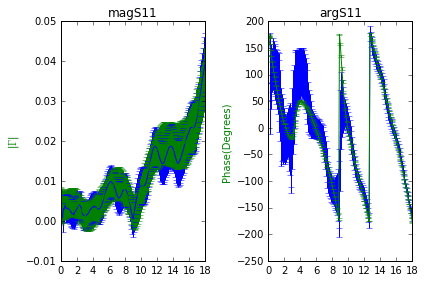

In [34]:
old_calrep=OnePortCalrepModel(os.path.join(r"C:\Share\ascii.dut\2014",'CTN102.asc'))
raw=OnePortRawModel(os.path.join(r"C:\Share\Ck_Std_raw_ascii",'CTN102.R5_061913'))
new_calrep=calrep(raw)
plot_calrep_comparision([old_calrep,new_calrep])

In [35]:
diff=frequency_model_difference(old_calrep,new_calrep)
print len(diff["magS11"])
print len(diff["uMgS11"])
print len(diff["Frequency"])

133
133
133


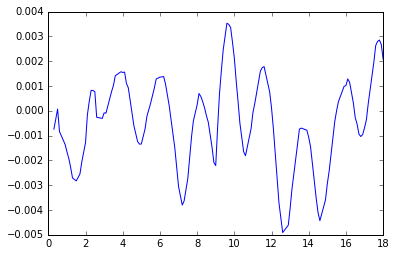

In [36]:
plt.plot(np.array(diff["Frequency"]),np.array(diff["magS11"]))



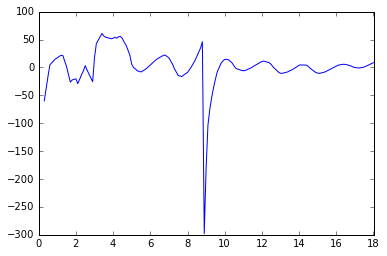

In [37]:
plt.plot(np.array(diff["Frequency"]),np.array(diff["argS11"]))

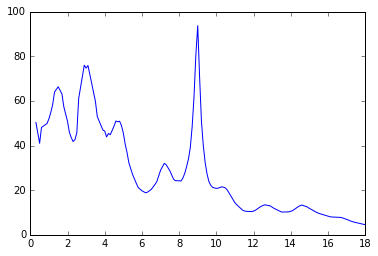

In [38]:
plt.plot(np.array(diff["Frequency"]),np.array(diff["uAgS11"]))

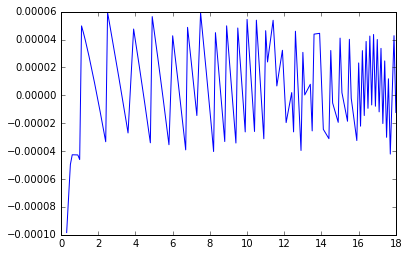

In [39]:
plt.plot(np.array(diff["Frequency"]),np.array(diff["uMgS11"]))

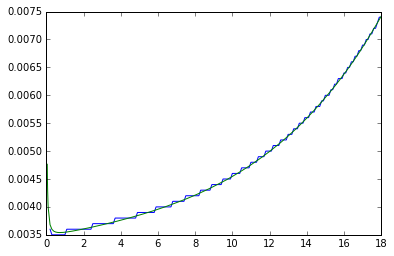

In [40]:
plt.plot(old_calrep["Frequency"],old_calrep["uMgS11"])
plt.plot(new_calrep["Frequency"],np.array(new_calrep["uMgS11"]))

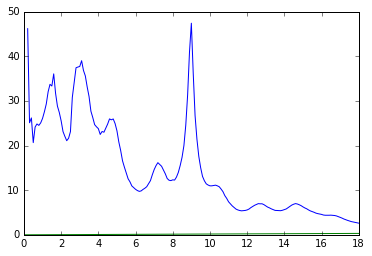

In [41]:
plt.plot(old_calrep["Frequency"],old_calrep["uAbS11"])
plt.plot(new_calrep["Frequency"],np.array(new_calrep["uAbS11"]))

average_columns is ['magS11', 'argS11', 'Efficiency']


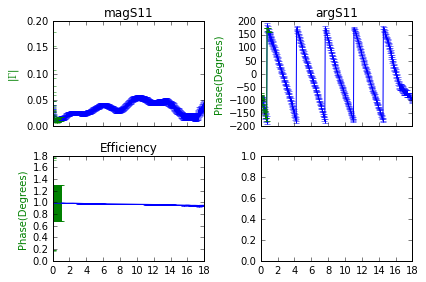

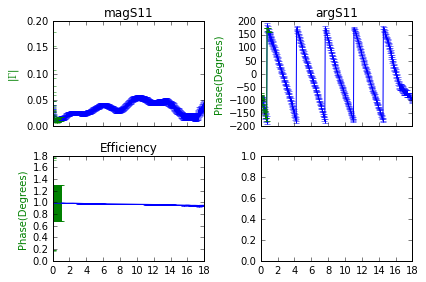

In [42]:
old_calrep=PowerCalrepModel(os.path.join(r"C:\Share\ascii.dut\2014",'CTNP13.ASC'))
raw=PowerRawModel(os.path.join(r"C:\Share\Ck_Std_raw_ascii",'CTNP13.A2_032101'))
new_calrep=calrep(raw)
plot_calrep_comparision([old_calrep,new_calrep])

In [43]:
old_calrep.joined_table.column_names

['Frequency',
 'magS11',
 'uMbS11',
 'uMaS11',
 'uMdS11',
 'uMgS11',
 'argS11',
 'uAbS11',
 'uAaS11',
 'uAdS11',
 'uAgS11',
 'Efficiency',
 'uEs',
 'uEc',
 'uEe',
 'Calibration_Factor',
 'uCs',
 'uCc',
 'uCe']